### Partition elements using Unstructured library 

In [ ]:
# It may take longer to install the package
!pip install -qU \
    "unstructured[pdf]==0.12.4" \
    "semantic-router==0.0.24"

Start by downloading and processing an ArXiv paper.

In [1]:
from unstructured.partition.auto import partition

article_url = "https://arxiv.org/pdf/2402.05131.pdf"
elements = partition(url=article_url, strategy="hi_res", pdf_infer_table_structure=True)

/Users/jakit/customers/aurelio/semantic-router/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Conflict between variables skip_infer_table_types: ['pdf', 'jpg', 'png', 'xls', 'xlsx', 'heic'] and pdf_infer_table_structure: True, please reset skip_infer_table_types to turn on table extraction for PDFs.
This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.c

#### Define helper functions

Validate if parsed title element is a real title

In [2]:
import re

def is_valid_title(title: str) -> bool:
    # Rule 1: Title starts with a lowercase letter
    if re.match(r"^[a-z]", title):
        return False
    # Rule 2: Title has a special character (excluding :, -, and .)
    if re.search(r"[^\w\s:\-\.]", title):
        return False
    # Rule 3: Title ends with a dot
    if title.endswith("."):
        return False
    return True

Group elements by valid titles

In [3]:
from unstructured.documents.elements import Element
from colorama import Fore, Style


def group_elements_by_title(elements: list[Element]) -> dict:
    grouped_elements = {}
    current_title = "Untitled"  # Default title for initial text without a title

    for element in elements:
        element_dict = element.to_dict()

        if element_dict.get("type") == "Title":
            potential_title = element_dict.get("text", "Untitled")
            if is_valid_title(potential_title):
                print(f"{Fore.GREEN}{potential_title}: True{Style.RESET_ALL}")
                current_title = potential_title
            else:
                print(f"{Fore.RED}{potential_title}: False{Style.RESET_ALL}")
                continue
        else:
            if current_title not in grouped_elements:
                grouped_elements[current_title] = []
            else:
                grouped_elements[current_title].append(element)
    return grouped_elements

Generates chunks grouped elements using semantic RollingWindow splitter

In [17]:

from semantic_router.splitters import RollingWindowSplitter


def create_title_chunks(
    grouped_elements: dict, splitter: RollingWindowSplitter
) -> list:
    title_with_chunks = []
    for title, elements in grouped_elements.items():
        if not elements:
            continue
        combined_element_texts = []
        chunks = []

        for element in elements:
            if not element.text:
                continue
            element_dict = element.to_dict()
            if element_dict.get("type") == "Table":
                # Process accumulated text before the table
                if combined_element_texts:
                    splits = splitter(combined_element_texts)
                    print("-" * 80)
                    chunks.extend([split.content for split in splits])
                    combined_element_texts = []  # Reset combined texts after processing

                # Add table as a separate chunk
                table_text_html = element.metadata.text_as_html
                chunks.append(table_text_html)
            else:
                combined_element_texts.append(element.text)

        # Process any remaining accumulated text after the last table
        # or if no table was encountered

        if combined_element_texts:
            print(f"Combined Element Texts: {combined_element_texts}")

            splits = splitter(combined_element_texts)
            print("-" * 80)
            chunks.extend([split.content for split in splits])

        if chunks:
            title_with_chunks.append({"title": title, "chunks": chunks})

    return title_with_chunks

Display chunked text in colors

In [18]:
from IPython.display import display, HTML
import itertools


def print_chunks_by_title(chunks_by_title):
    color_cycle = itertools.cycle(["red", "green", "blue", "magenta"])
    html_output = ""
    for section in chunks_by_title:
        title = section["title"]
        chunks = section["chunks"]
        html_output += f"<h3 style='color: black;'>{title}</h3>"
        for chunk in chunks:
            color = next(color_cycle)
            html_output += f"<p style='color: {color};'>{chunk}</p>"
    display(HTML(html_output))

### Process the elements

In [19]:
import os
from semantic_router.encoders import OpenAIEncoder

encoder = OpenAIEncoder(openai_api_key=os.environ["OPENAI_API_KEY"])

splitter = RollingWindowSplitter(
    encoder=encoder,
    window_size=1,  # Compares each element with the previous one
    min_split_tokens=1,
    max_split_tokens=500,
    plot_splits=True,
)

In [20]:
grouped_elements = group_elements_by_title(elements)

et! ee: False
b e F 0 1: False
] L C . s c [: False
Financial Report Chunking for Eﬀective Retrieval Augmented Generation: True
Introduction: True
2 Jimeno Yepes et al.: False
1 https://www.sec.gov 2 https://www.sec.gov/files/cf-frm.pdf: False
2 Related work: True
4 Jimeno Yepes et al.: False
3 Methods: True
3.1 RAG setting for the experiments: True
3.2 Indexing and retrieval: True
7 https://weaviate.io/developers/weaviate 8 https://huggingface.co/sentence-transformers/multi-qa-mpnet-base-dot-: False
v1: False
3.3 Generation: True
Question: {query}: False
3.4 Chunking: True
3.5 Dataset: True
4 Results: True
11 https://platform.openai.com/docs/guides/embeddings/limitations-risks: False
10 Jimeno Yepes et al.: False
5 Discussion: True
12 Jimeno Yepes et al.: False
6 Conclusions and Future Work: True
References: True


Combined Element Texts: ['2 v 1 3 1 5 0 . 2 0 4 2 : v i X r a']


/Users/jakit/customers/aurelio/semantic-router/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jakit/customers/aurelio/semantic-router/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jakit/customers/aurelio/semantic-router/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakit/customers/aurelio/semantic-router/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jakit/customers/aurelio/semantic-router/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar

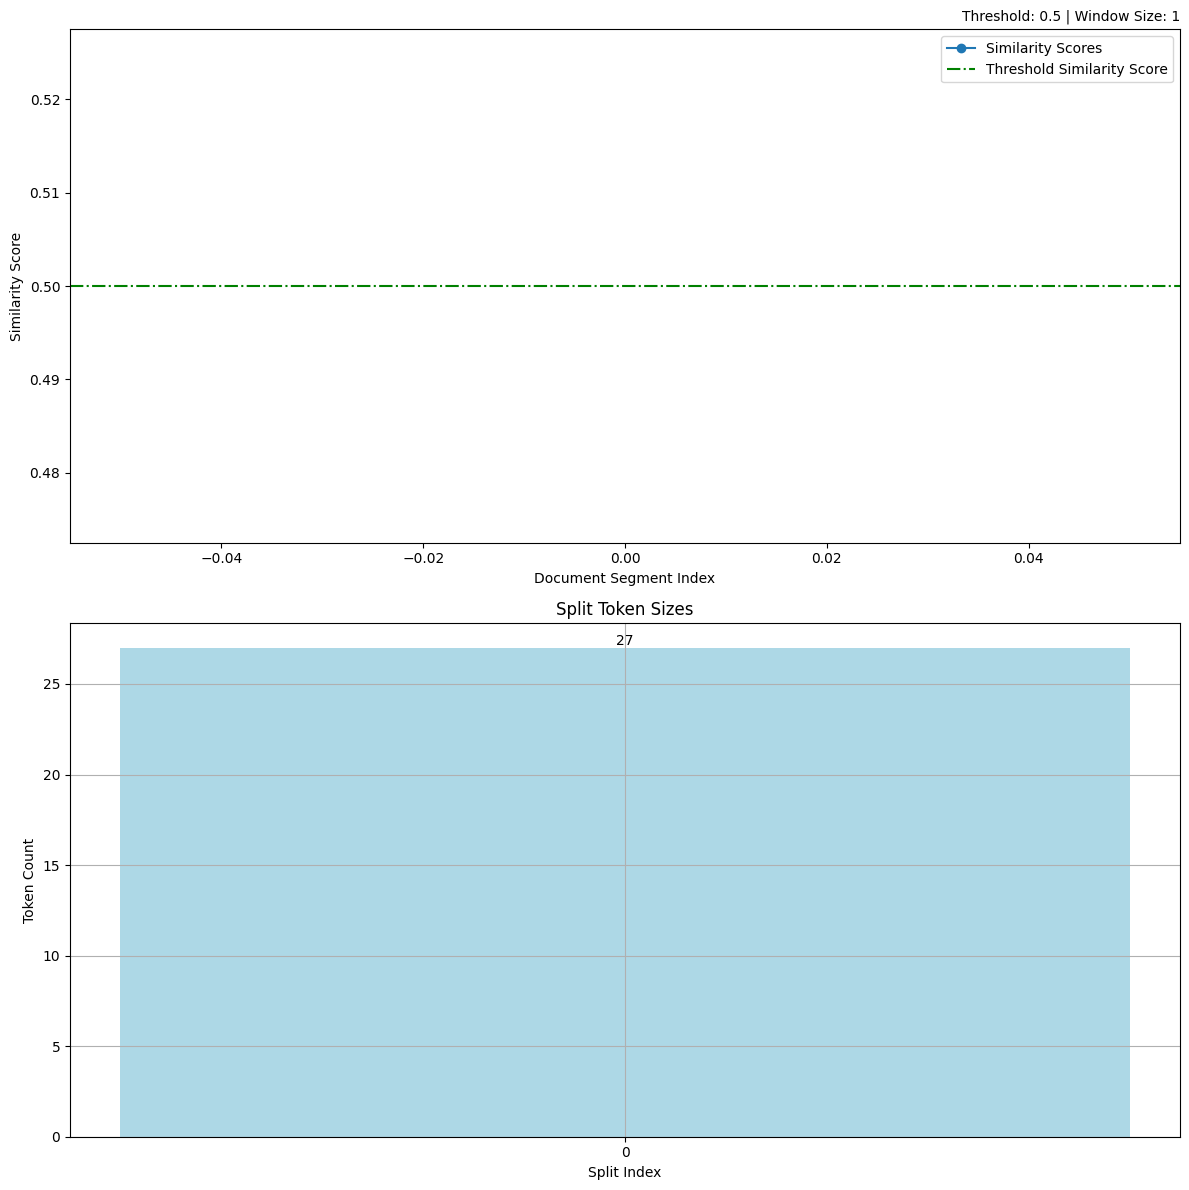

--------------------------------------------------------------------------------
Combined Element Texts: ['Unstructured Technologies Sacramento, CA, USA leah@unstructured.io https://unstructured.io', 'Abstract. Chunking information is a key step in Retrieval Augmented Generation (RAG). Current research primarily centers on paragraph- level chunking. This approach treats all texts as equal and neglects the information contained in the structure of documents. We propose an expanded approach to chunk documents by moving beyond mere paragraph-level chunking to chunk primary by structural element com- ponents of documents. Dissecting documents into these constituent ele- ments creates a new way to chunk documents that yields the best chunk size without tuning. We introduce a novel framework that evaluates how chunking based on element types annotated by document understanding models contributes to the overall context and accuracy of the informa- tion retrieved. We also demonstrate how this 

2024-02-26 13:24:20 INFO semantic_router.utils.logger Optimal threshold 0.7912938086798802 found with median tokens (273.0) in target range (1-500).
2024-02-26 13:24:20 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 273
  - Maximum Token Size of Split: 273
  - Similarity Split Ratio: 0.00


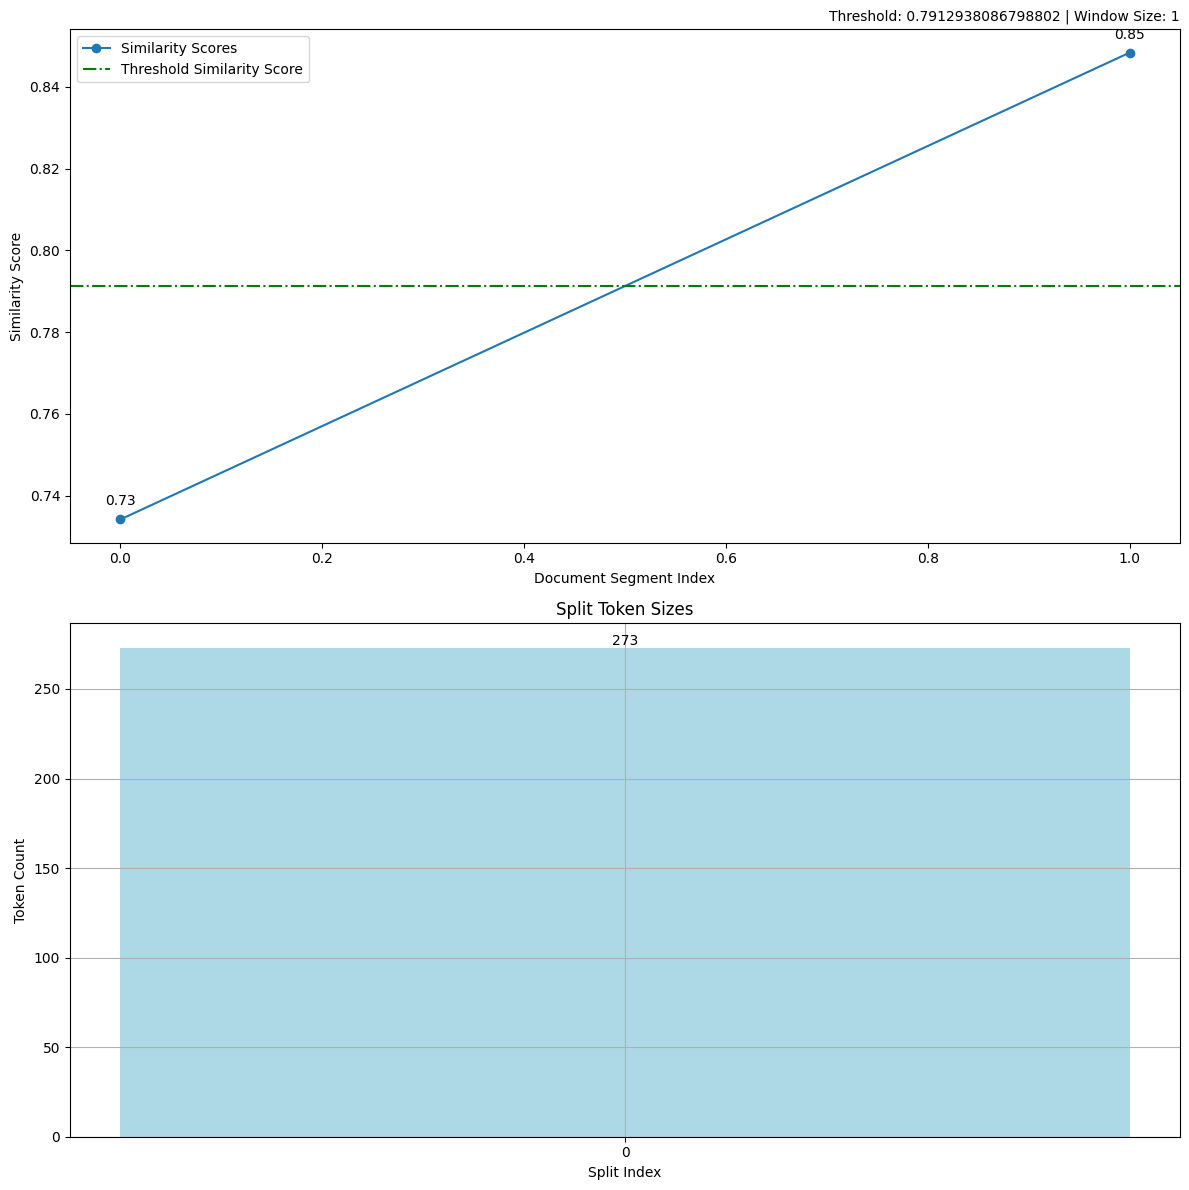

--------------------------------------------------------------------------------
Combined Element Texts: ['contents of extensive documents [25,22,18]. By dissecting large volumes of text into smaller, more focused segments, LLMs can process each part with greater precision, ensuring a thorough understanding of each section. This segmented approach allows for meticulous analysis of unstructured data, enabling LLMs to construct a more comprehensive and coherent understanding of the entire docu- ment [41]. There remains a challenge in ensuring factual accuracy and relevance in the generated responses, especially when dealing with complex or extensive information.', 'Recently, Retrieval Augmented Generation (RAG) [21,12] has been devel- oped to address the hallucination problem with LLMs [15,43] when recovering factual information directly from an LLM. In RAG, instead of answering a user query directly using an LLM, the user query is used to retrieve documents or segments from a corpus and

2024-02-26 13:24:21 INFO semantic_router.utils.logger Optimal threshold 0.8513633459440277 found with median tokens (157.0) in target range (1-500).
2024-02-26 13:24:21 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 64
  - Maximum Token Size of Split: 502
  - Similarity Split Ratio: 0.67


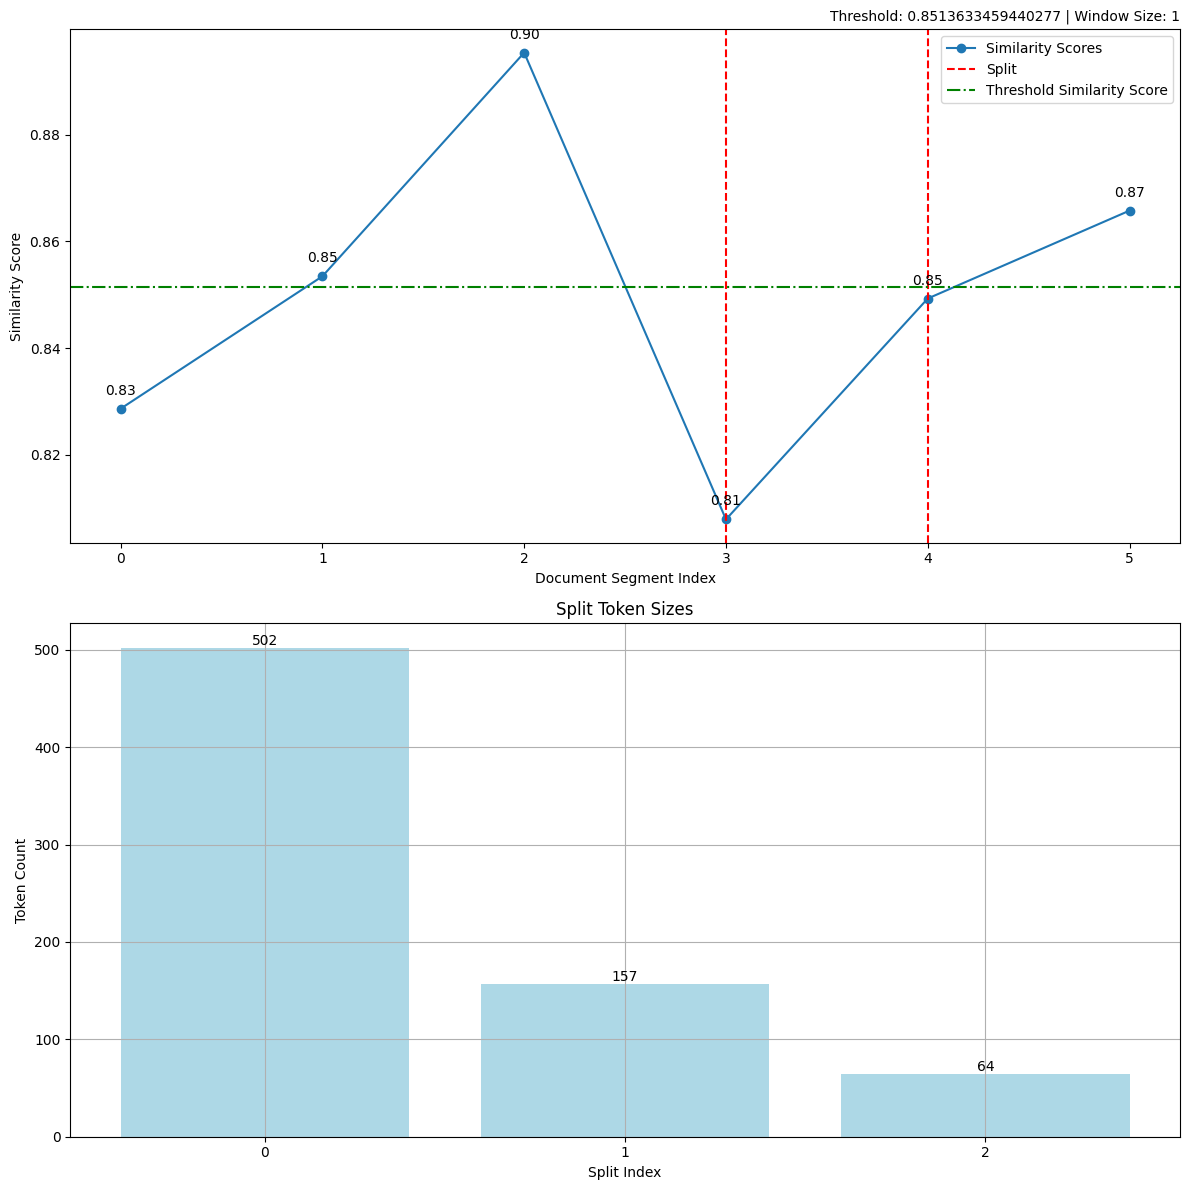

--------------------------------------------------------------------------------
Combined Element Texts: ['Exploring the structure of ﬁnancial reports is an exceptional area for es- tablishing optimal principles for chunking. The intricate nature of document structures and contents has resulted in most of the work processing ﬁnancial reports focusing on the identiﬁcation of structural elements. Among previous work, we ﬁnd El-Haj et al. [10] and the FinTOC challenges [17,4,11] that have worked at the document structure level for UK and French ﬁnancial reports. Ad-', '3 https://www.cnbc.com/2023/12/19/gpt-and-other-ai-models-cant-analyze- an-sec-filing-researchers-find.html', 'ditionally, there is recent work that considers U.S. SEC reports, which includes DocLayNet [33] and more speciﬁcally with the report tables in FinTabNet [45]. On the side of ﬁnancial models, there is work in sentiment analysis in ﬁ- nance [37], which includes the pre-training of specialised models such as Fin- BERT

2024-02-26 13:24:21 INFO semantic_router.utils.logger Optimal threshold 0.8371609601655312 found with median tokens (199.0) in target range (1-500).
2024-02-26 13:24:21 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 146
  - Maximum Token Size of Split: 362
  - Similarity Split Ratio: 0.67


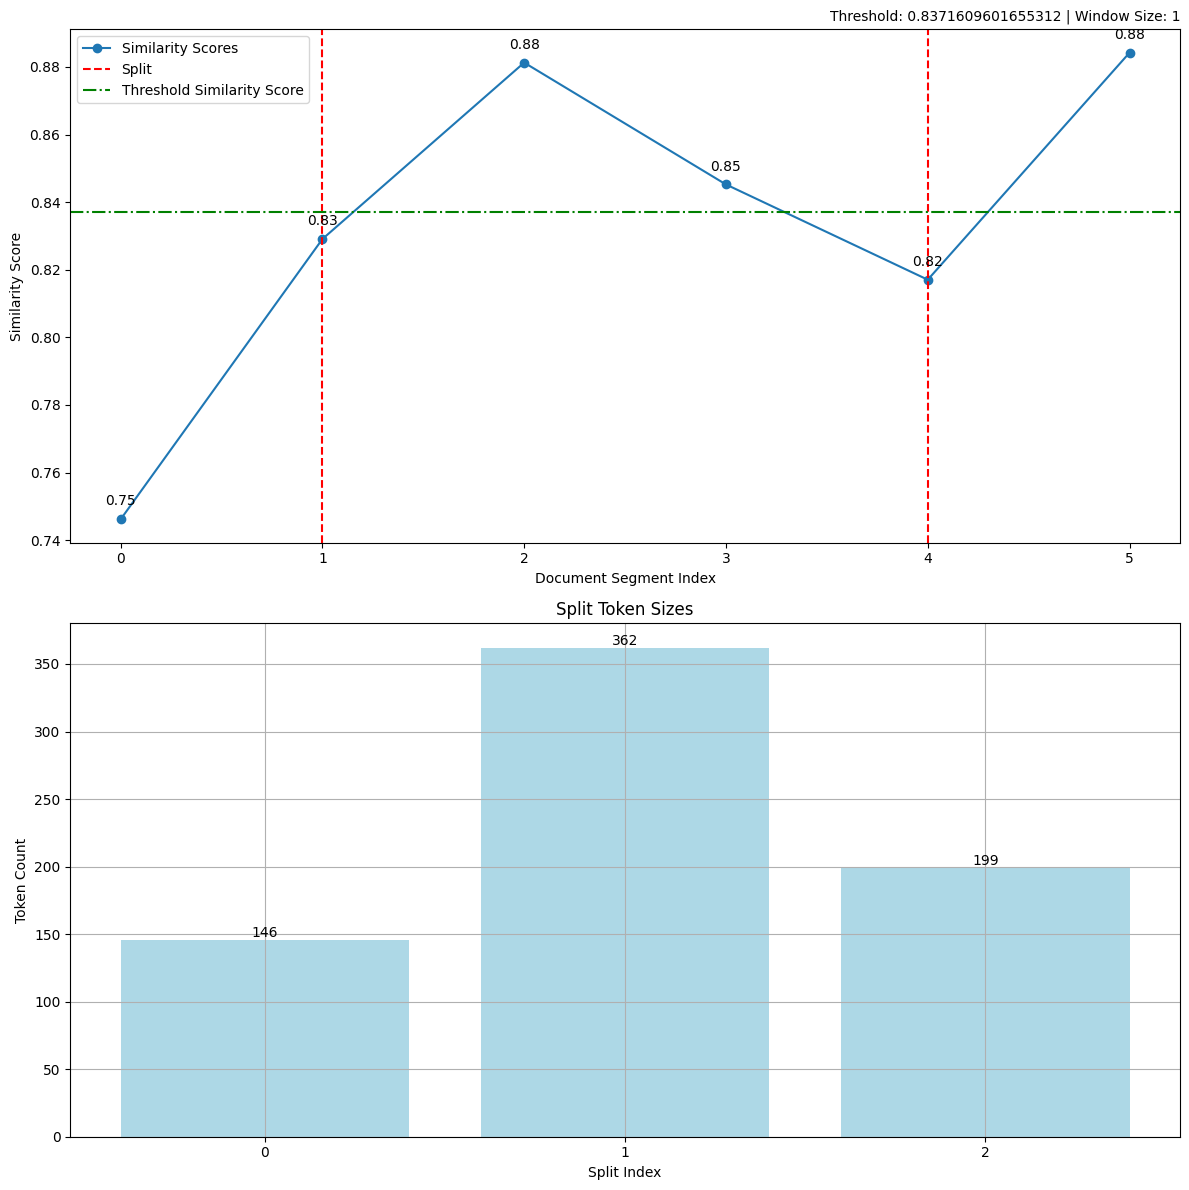

--------------------------------------------------------------------------------
Combined Element Texts: ['Financial Report Chunking for Eﬀective Retrieval Augmented Generation', 'document, the document is split into chunks and the chunks are indexed into a vector database (vectordb). When a question is sent to the RAG system, the top-k chunks most similar to the question are retrieved from the vector database and used to generate the answer using a large language model as generator. In order to retrieve chunks from the vector database, the question is encoded into a vector that is compared to the vector previously generated from the chunks. To prompt the generator, the question is converted into a set of instructions that instruct the LLM to ﬁnd the answer within the top-k retrieved chunks.', 'question vectordb top k question vector chunks encoder v | generator —+ answer * question to prompt + rome', 'Fig. 1. RAG steps to answer a question about a document', 'In our experiments, we mo

2024-02-26 13:24:22 INFO semantic_router.utils.logger Optimal threshold 0.8004077245399883 found with median tokens (46.0) in target range (1-500).
2024-02-26 13:24:22 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 15
  - Maximum Token Size of Split: 161
  - Similarity Split Ratio: 0.67


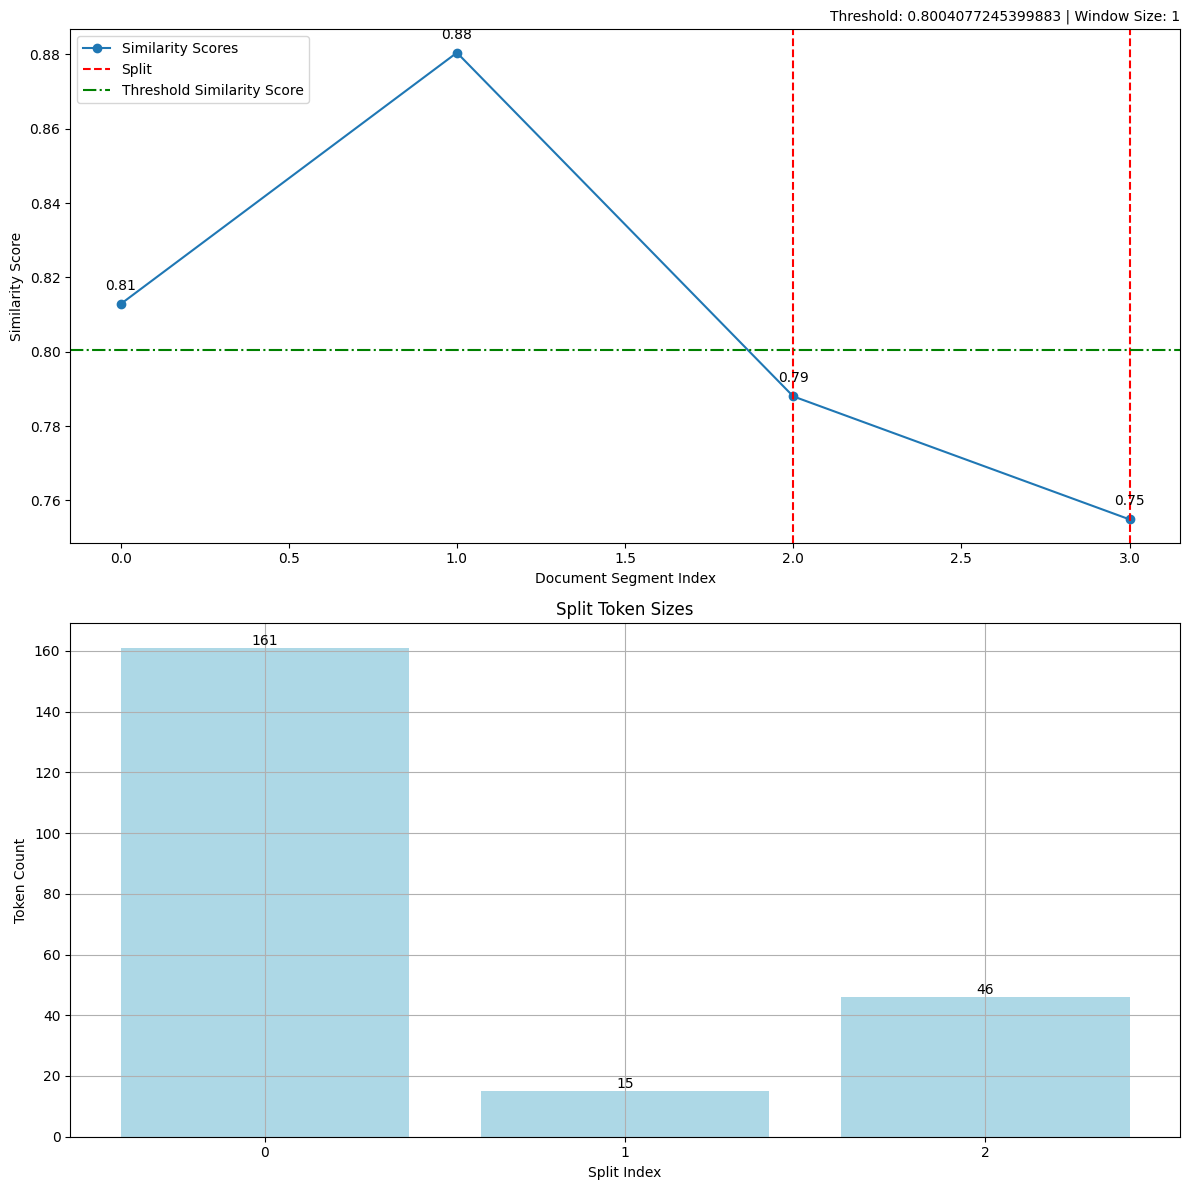

--------------------------------------------------------------------------------
Combined Element Texts: ['As shown in ﬁgure 2, to index a document, ﬁrst the document is split into chunks, then each chunk is processed by an encoder model and then indexed into the vector database. Based on the chunking strategy a document will be split into a larger or smaller set of chunks.', 'chunks vectors', 'Fig. 2. Indexing of document chunks into the vector database', 'ttps://huggingface. co/sentence-transformers/multi-qa-mpnet-base-dot-', '6 Jimeno Yepes et al.', 'As shown in ﬁgure 1, to retrieve chunks relevant to a question, the question is converted into a vector representation and the vector database returns a ranked list of chunks based on the similarity between question vector and the chunks in the database. Weaviate implements an approximate nearest neighbours algo- rithm [28] as their retrieval approach, which supports fast retrieval with high accuracy. In our experiments, we retrieve the

2024-02-26 13:24:23 INFO semantic_router.utils.logger Optimal threshold 0.7219220831968602 found with median tokens (94.0) in target range (1-500).
2024-02-26 13:24:23 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 8
  - Maximum Token Size of Split: 100
  - Similarity Split Ratio: 0.67


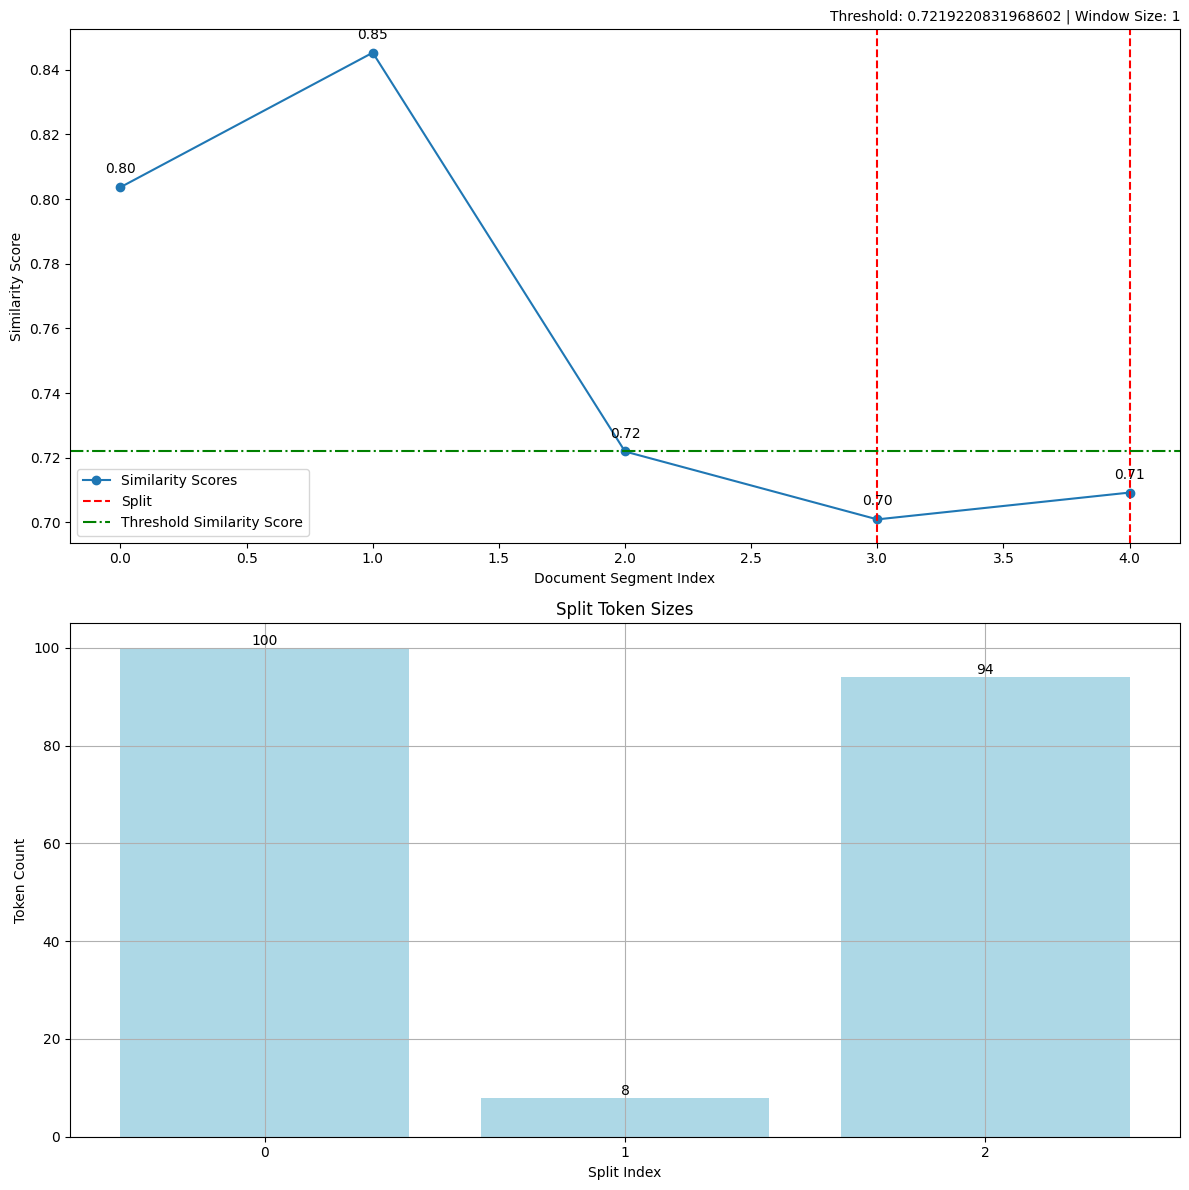

--------------------------------------------------------------------------------
Combined Element Texts: ['We have used GPT-4 [31] as the generator, which has shown best performance compared to earlier versions. As well, its performance was better compared to existing open source alternatives [22] such as Mixtral [16]. We used the prompt presented in ﬁgure 3 that we designed on another similar RAG implementation with diﬀerent document types. The prompt conditions the answer to the query and the chunks, referred to as source, and if the generator cannot answer it should return No answer.', 'please answer the question below by referencing the list of sources provided after the question; if the question can not be answered just respond ’No answer’. The sources are listed after "Sources:".  Question: {query}  Sources: {key} - {source} ... ', 'Sources: {key} - {source} ...', 'Fig. 3. Example prompt template used by the generator']


2024-02-26 13:24:24 INFO semantic_router.utils.logger Optimal threshold 0.7865543500746407 found with median tokens (92.5) in target range (1-500).
2024-02-26 13:24:24 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 12
  - Maximum Token Size of Split: 173
  - Similarity Split Ratio: 0.50


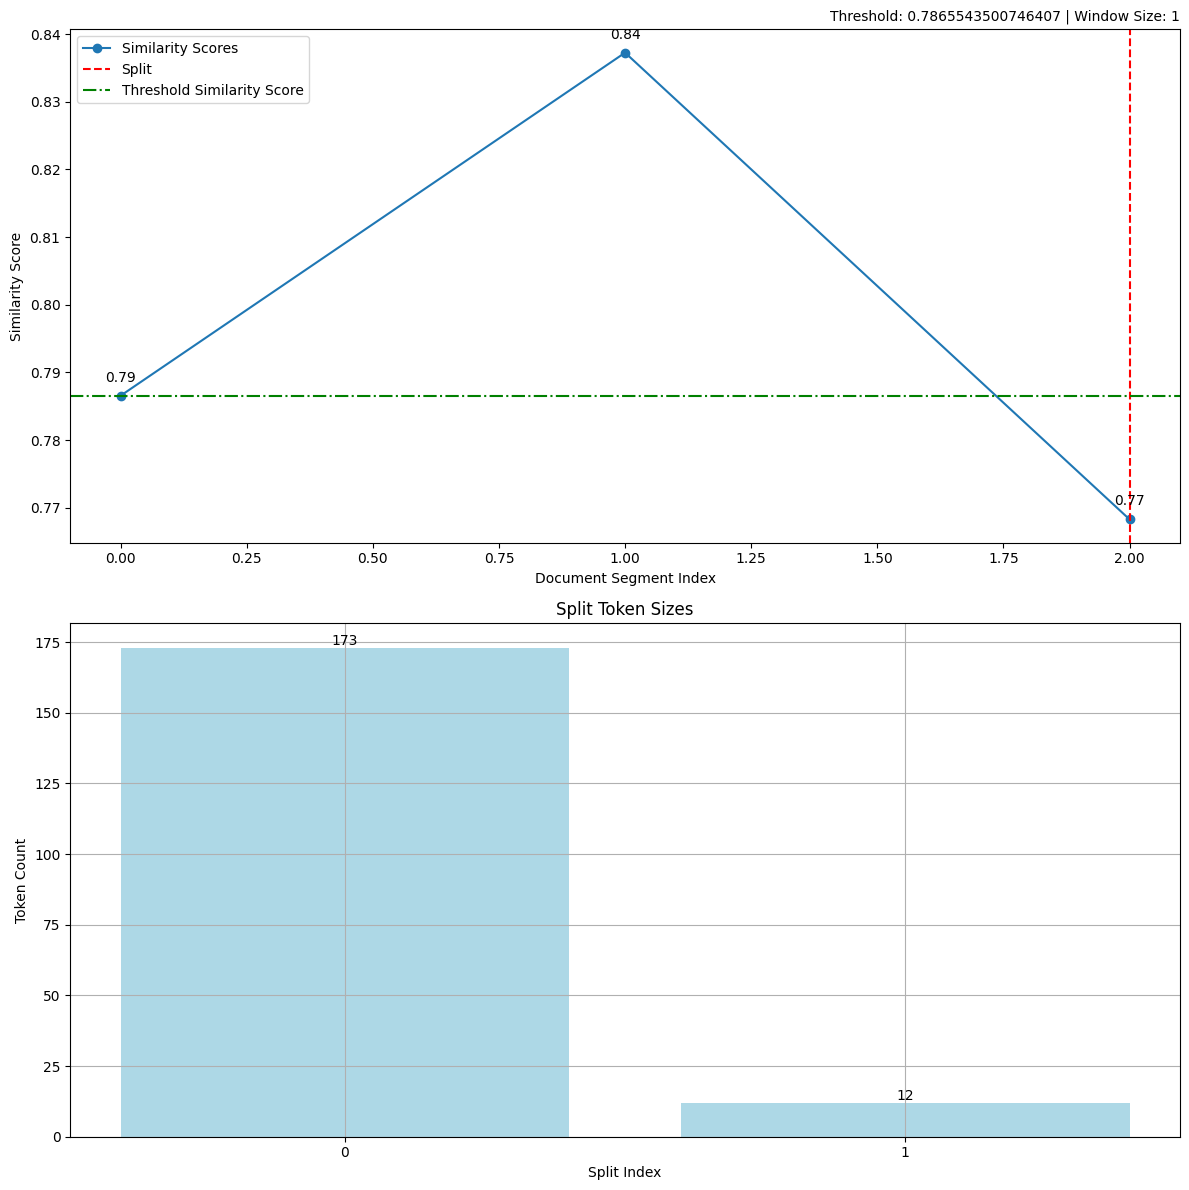

--------------------------------------------------------------------------------
Combined Element Texts: ['In addition to chunking based on the number of tokens, we have processed the documents using computer vision and natural language processing to extract elements identiﬁed in the reports. The list of elements considered are provided by the Unstructured9 open source library. From the set of processing strategies, 9 https://unstructured-io.github.io/unstructured/introduction.html#', 'elements', 'Financial Report Chunking for Eﬀective Retrieval Augmented Generation', 'we use Chipper, a vision encoder decoder10 model inspired by Donut [20] to showcase the performance diﬀerence. The Chipper model outputs results as a JSON representation of the document, listing elements per page characterized by their element type. Additionally, Chipper provides a bounding box enclosing each element on the page and the corresponding element text.', 'These elements are sometimes short to be considered as

2024-02-26 13:24:25 INFO semantic_router.utils.logger Optimal threshold 0.7759885849518695 found with median tokens (73.0) in target range (1-500).
2024-02-26 13:24:25 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 5
  - Splits by Threshold: 4
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 15
  - Maximum Token Size of Split: 210
  - Similarity Split Ratio: 0.80


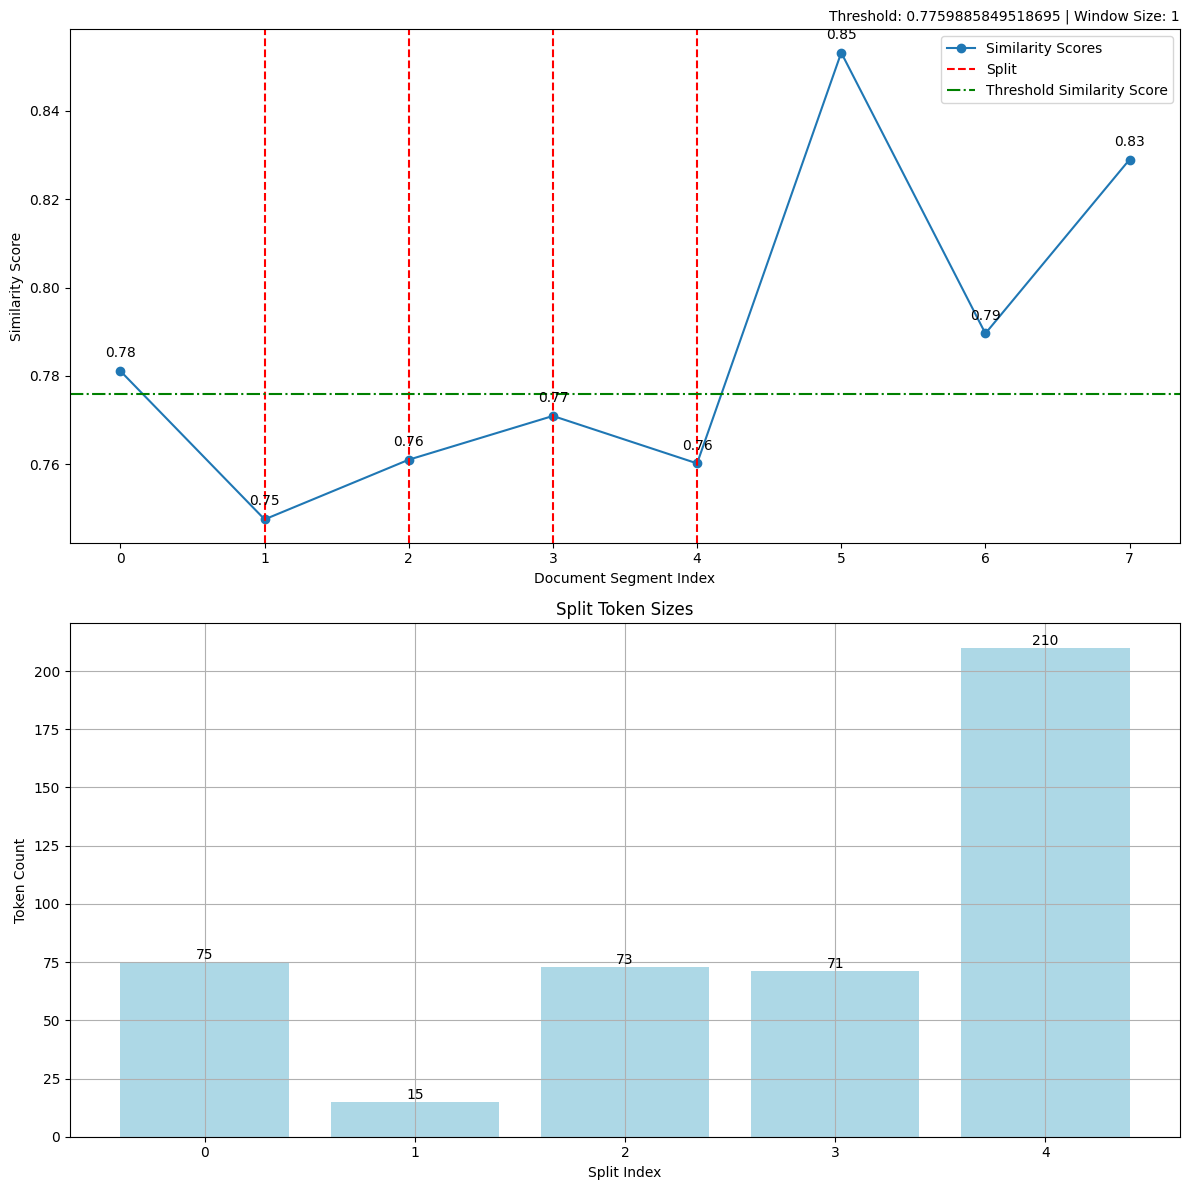

--------------------------------------------------------------------------------


2024-02-26 13:24:26 INFO semantic_router.utils.logger Optimal threshold 0.7356350410401438 found with median tokens (23.0) in target range (1-500).
2024-02-26 13:24:26 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 8
  - Maximum Token Size of Split: 198
  - Similarity Split Ratio: 0.67


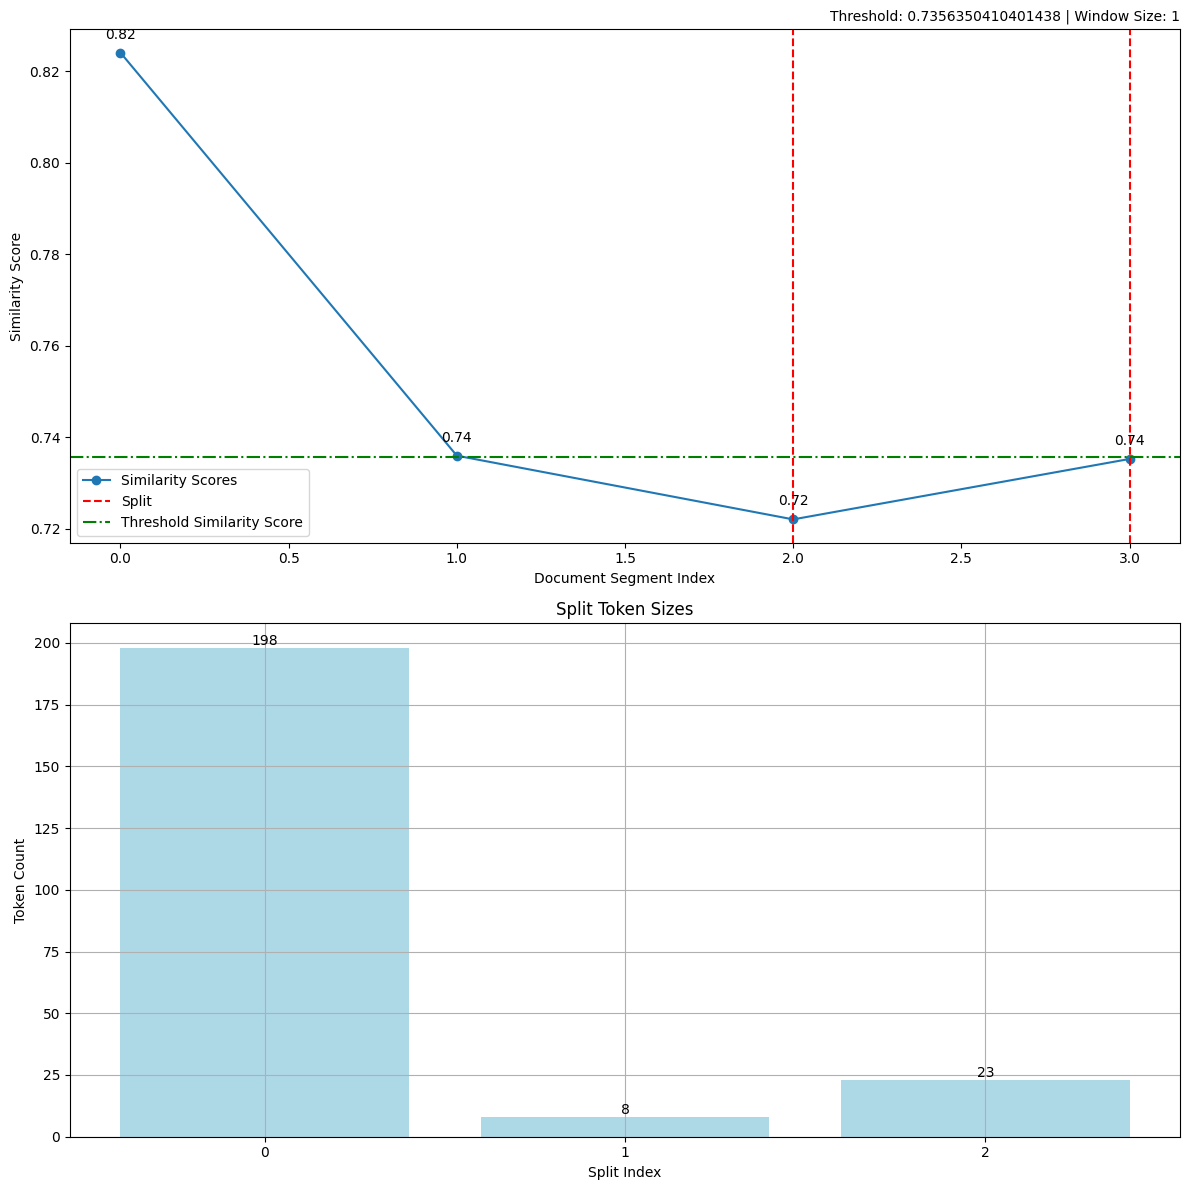

--------------------------------------------------------------------------------
Combined Element Texts: ['in the document, that allows for a closer evaluation of the results. Based on the page number, evidence contexts are located in diﬀerent areas in the documents, ranging from the ﬁrst page in some cases up to page 304 in one instance. The mean page number to ﬁnd the evidence is 54.58 with a standard deviation of 43.66, which shows that evidence contexts to answer the questions are spread within a document. These characteristics make FinanceBench a perfect dataset for evaluating RAG. An example instance is available in table 2.']


2024-02-26 13:24:26 INFO semantic_router.utils.logger Optimal threshold 0.7993056373716161 found with median tokens (14.0) in target range (1-500).
2024-02-26 13:24:26 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 10
  - Maximum Token Size of Split: 95
  - Similarity Split Ratio: 0.67


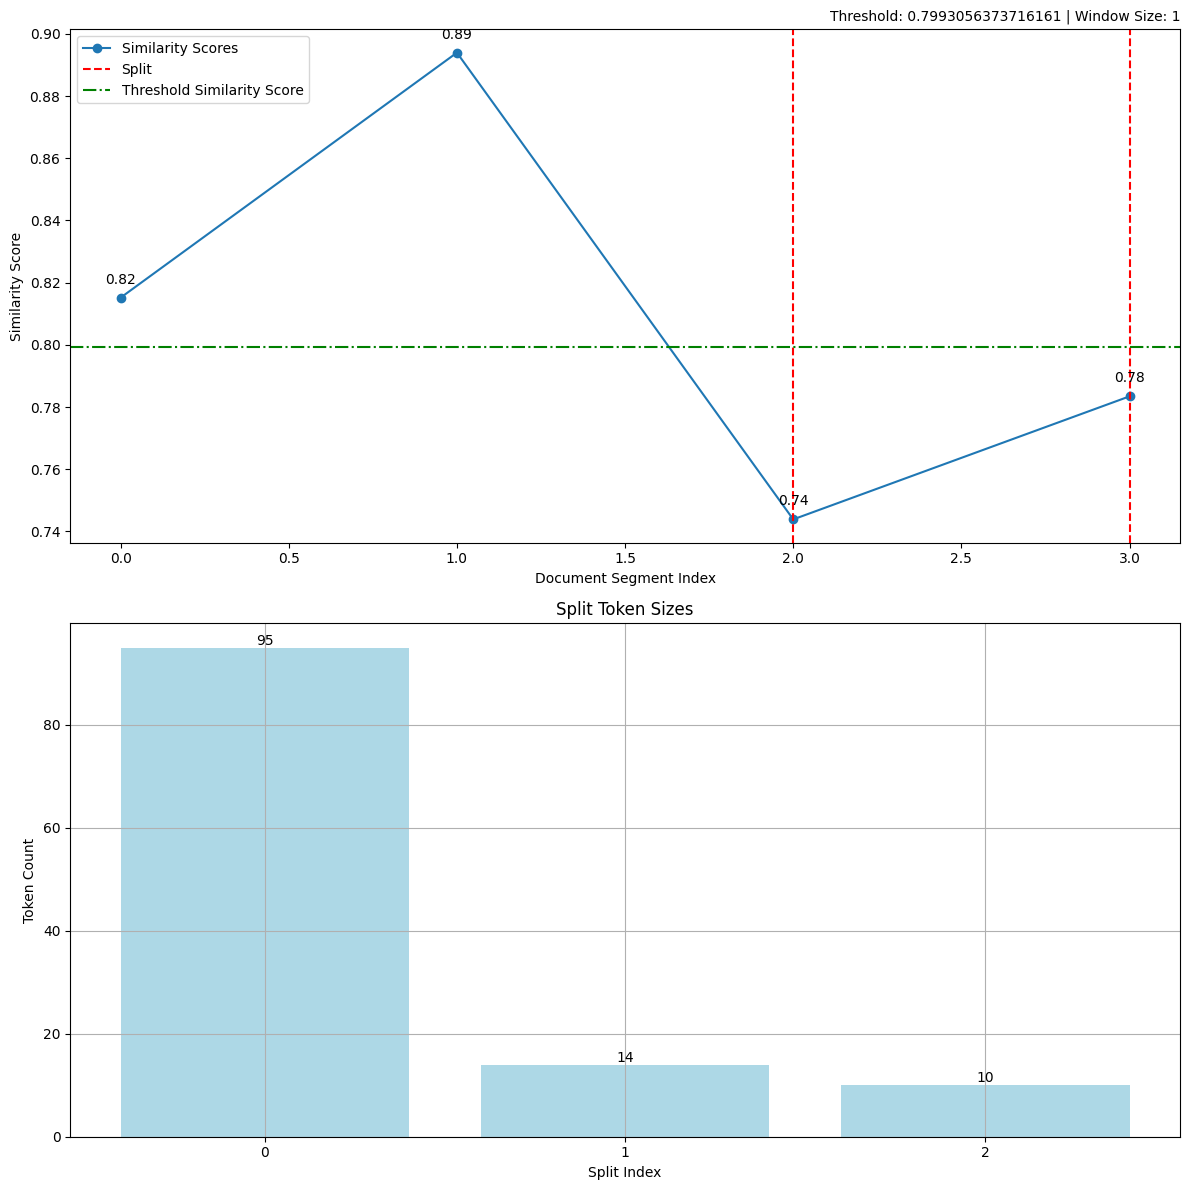

--------------------------------------------------------------------------------


2024-02-26 13:24:27 INFO semantic_router.utils.logger Optimal threshold 0.7946781280578719 found with median tokens (209.0) in target range (1-500).
2024-02-26 13:24:27 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 209
  - Maximum Token Size of Split: 209
  - Similarity Split Ratio: 0.00


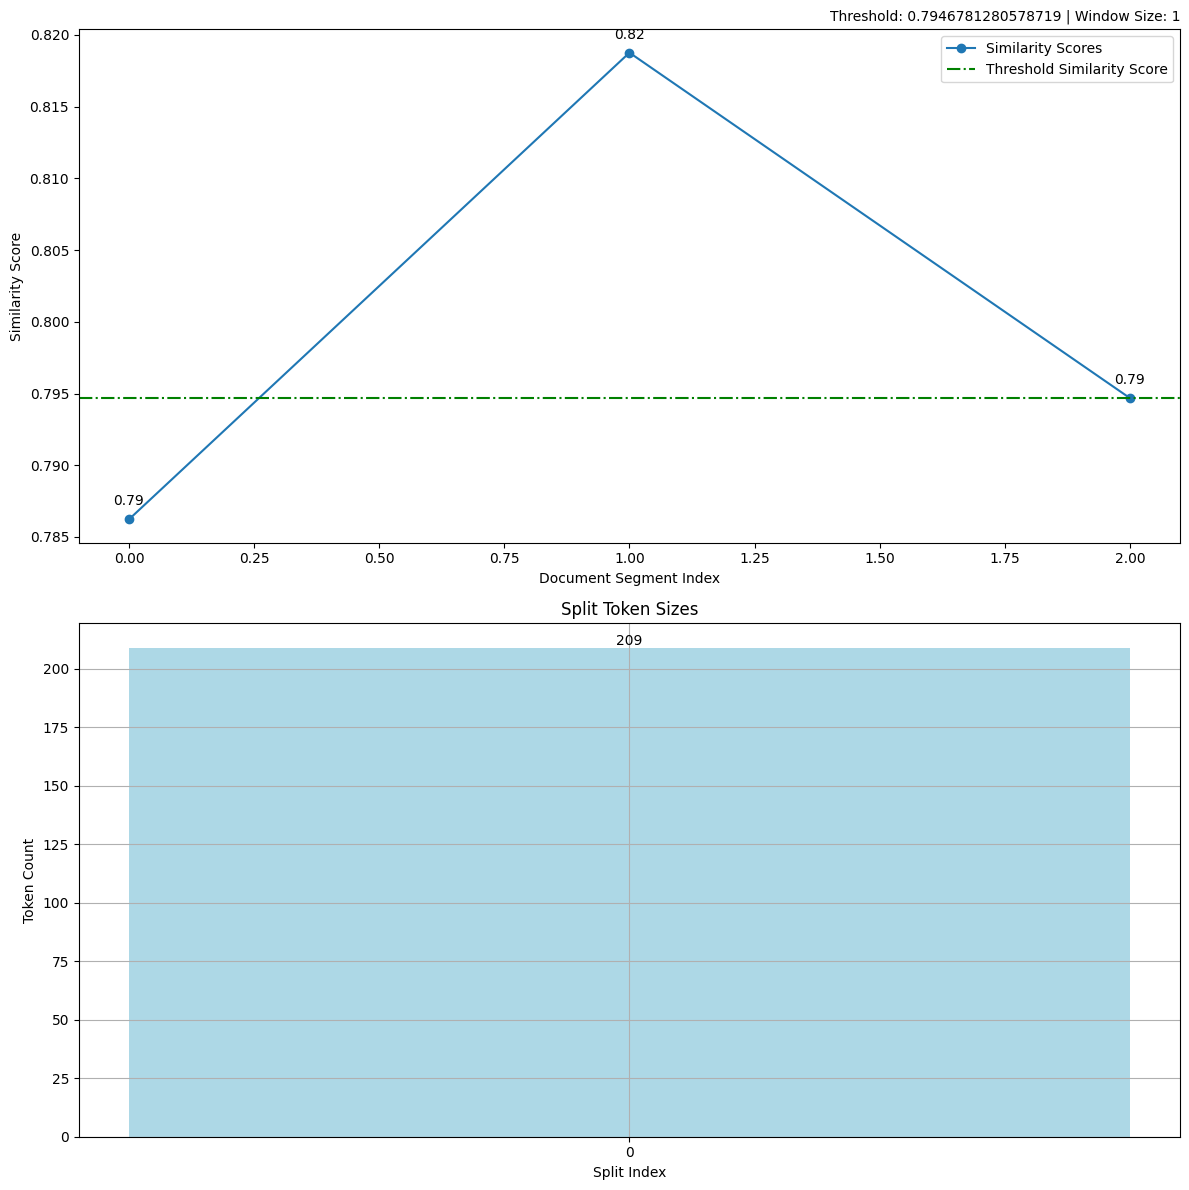

--------------------------------------------------------------------------------


2024-02-26 13:24:28 INFO semantic_router.utils.logger Optimal threshold 0.7079124801171096 found with median tokens (15.0) in target range (1-500).
2024-02-26 13:24:28 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 15
  - Maximum Token Size of Split: 15
  - Similarity Split Ratio: 0.00


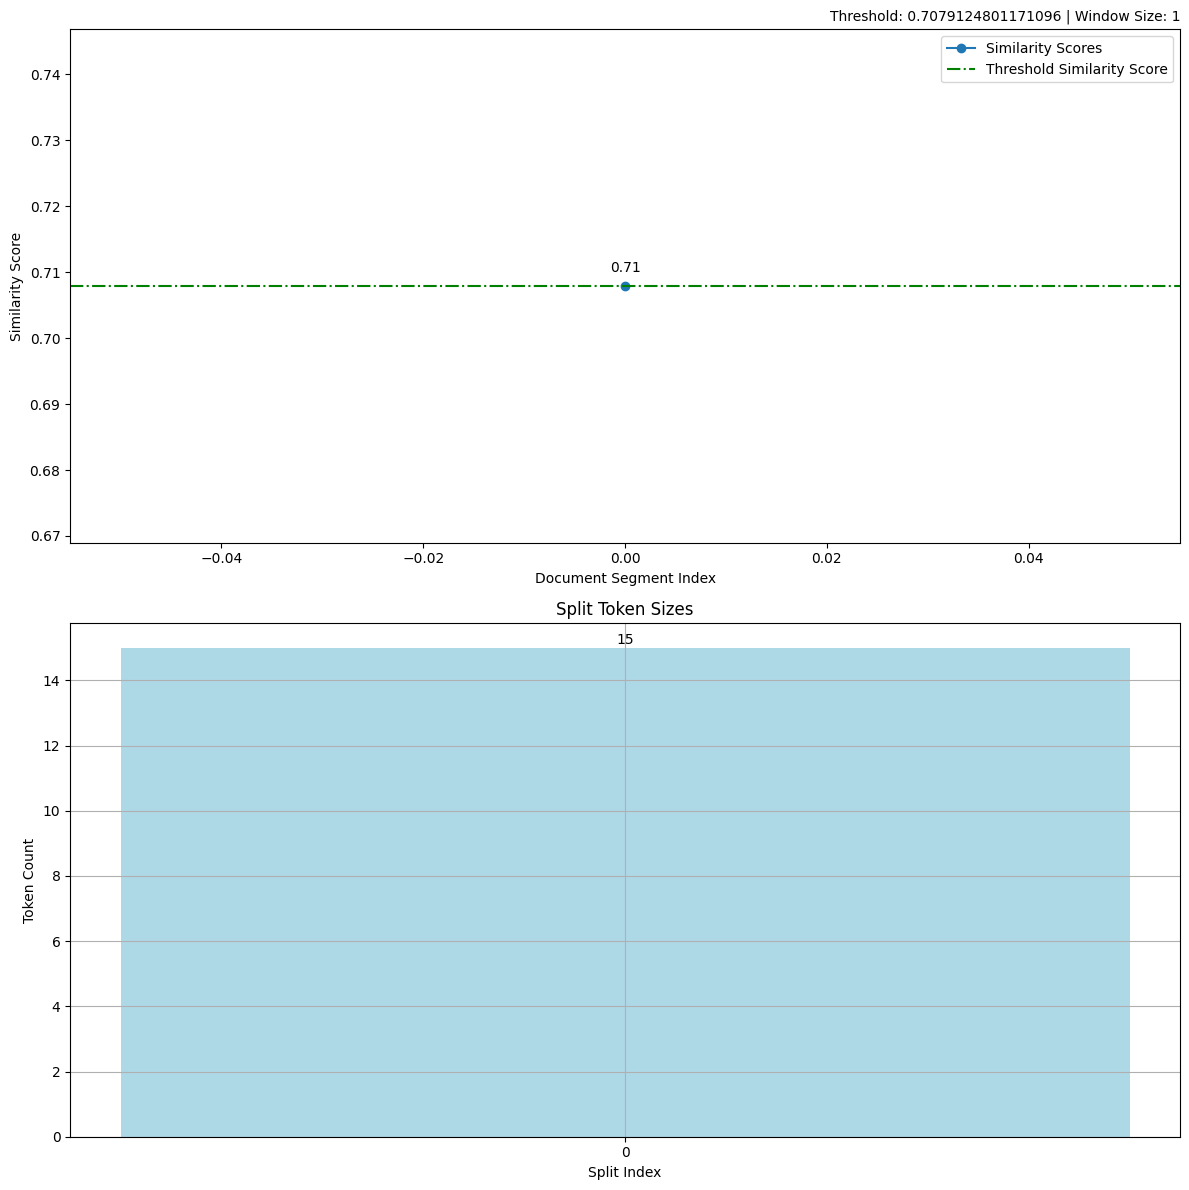

--------------------------------------------------------------------------------


2024-02-26 13:24:29 INFO semantic_router.utils.logger Optimal threshold 0.8324383000723908 found with median tokens (110.5) in target range (1-500).
2024-02-26 13:24:29 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 6
  - Splits by Threshold: 5
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 57
  - Maximum Token Size of Split: 254
  - Similarity Split Ratio: 0.83


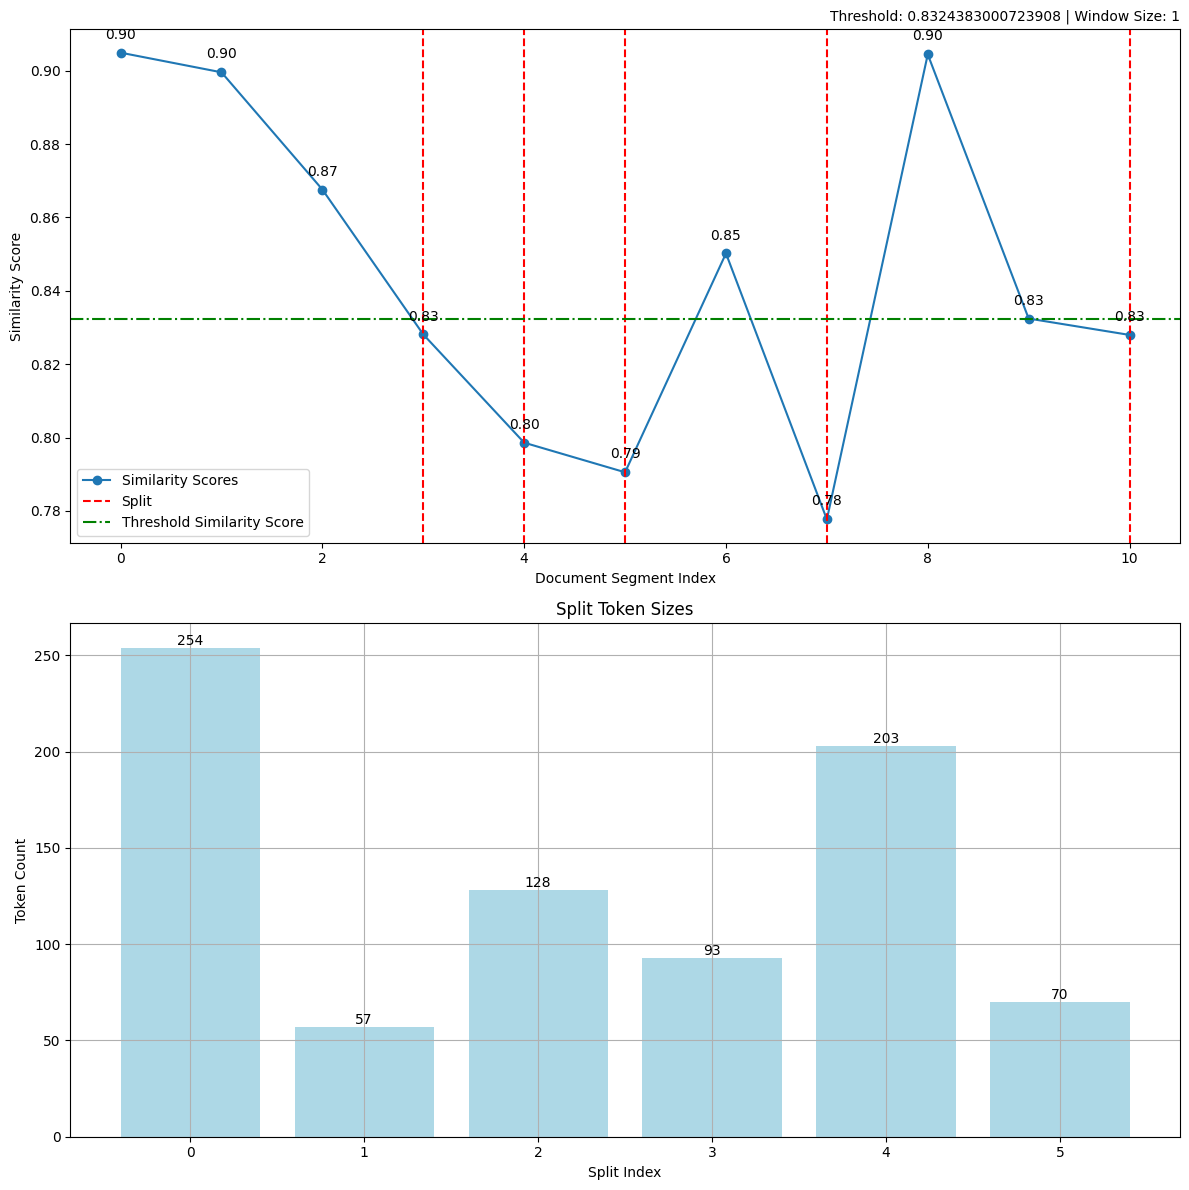

--------------------------------------------------------------------------------


2024-02-26 13:24:29 INFO semantic_router.utils.logger Optimal threshold 0.8128022034342155 found with median tokens (33.0) in target range (1-500).
2024-02-26 13:24:29 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 33
  - Maximum Token Size of Split: 33
  - Similarity Split Ratio: 0.00


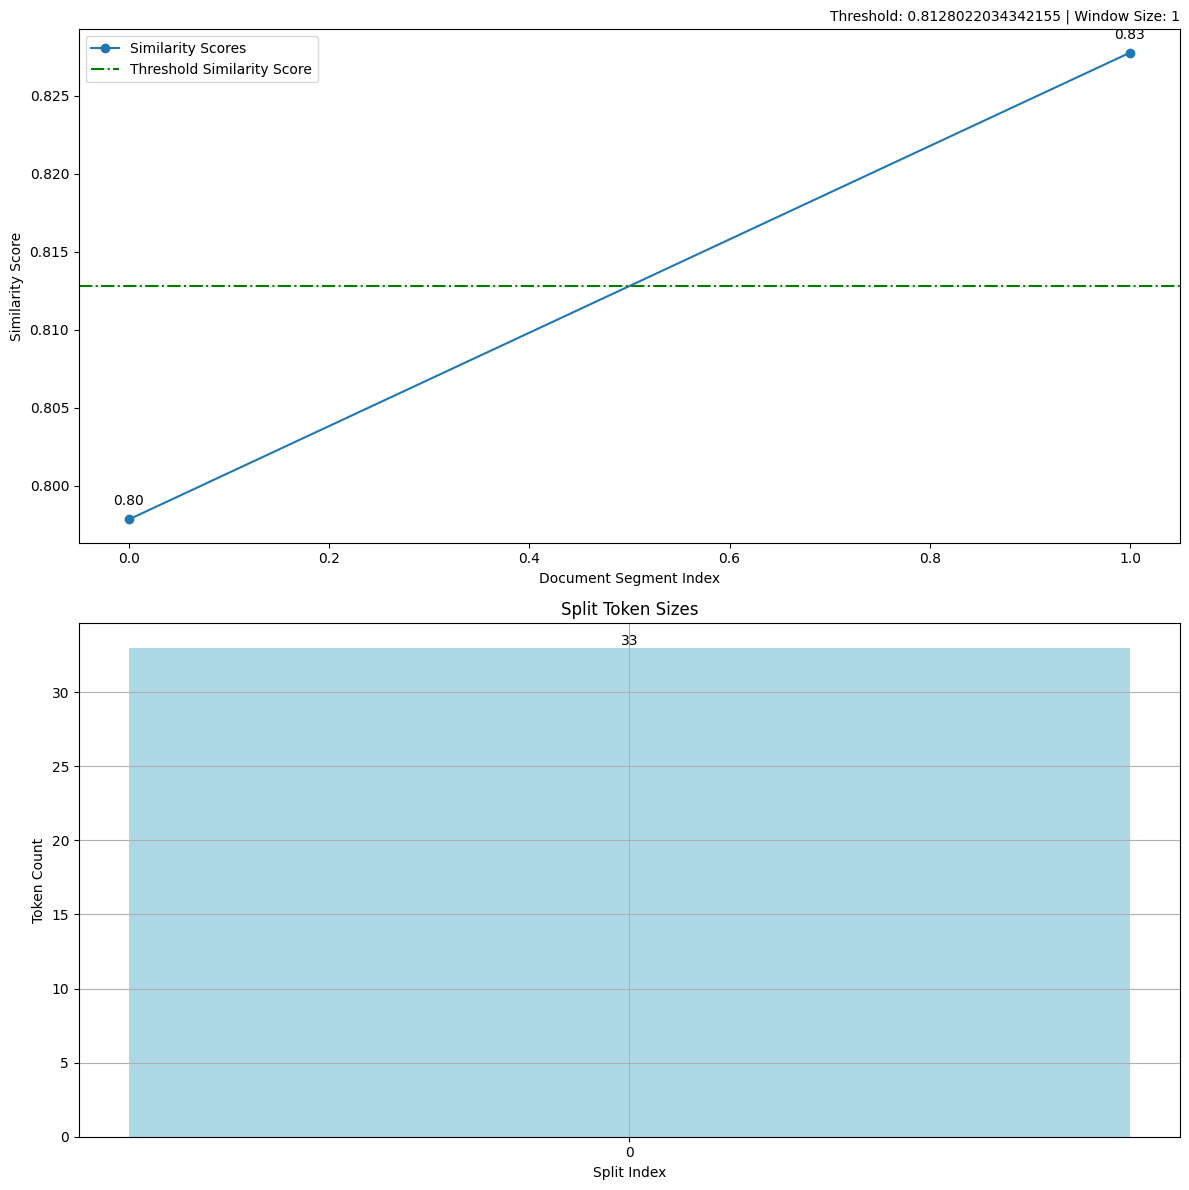

--------------------------------------------------------------------------------
Combined Element Texts: ['We have observed that using basic 512 chunking strategies produces results most similar to the Unstructured element-based approach, which may be due to the fact that 512 tokens share a similar length with the token size within our element-based chunks and capture a long context, but fail keep a coherent context in some cases, leaving out relevant information required for Q&A. This is further observed when considering the ROUGE and BLEU scores in table 4, where the chunk contexts for the baseline have lower scores.', 'These ﬁndings support existing research stating that the best basic chunk size varies from data to data [3]. These results show, as well, that our method adapts to diﬀerent documents without tuning. Our method relies on the struc-', 'tural information that is present in the document’s layout to adjust the chunk size automatically.', 'We have evaluated aggregating the 

2024-02-26 13:24:30 INFO semantic_router.utils.logger Optimal threshold 0.786452236757286 found with median tokens (173.5) in target range (1-500).
2024-02-26 13:24:30 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 8
  - Maximum Token Size of Split: 241
  - Similarity Split Ratio: 0.75


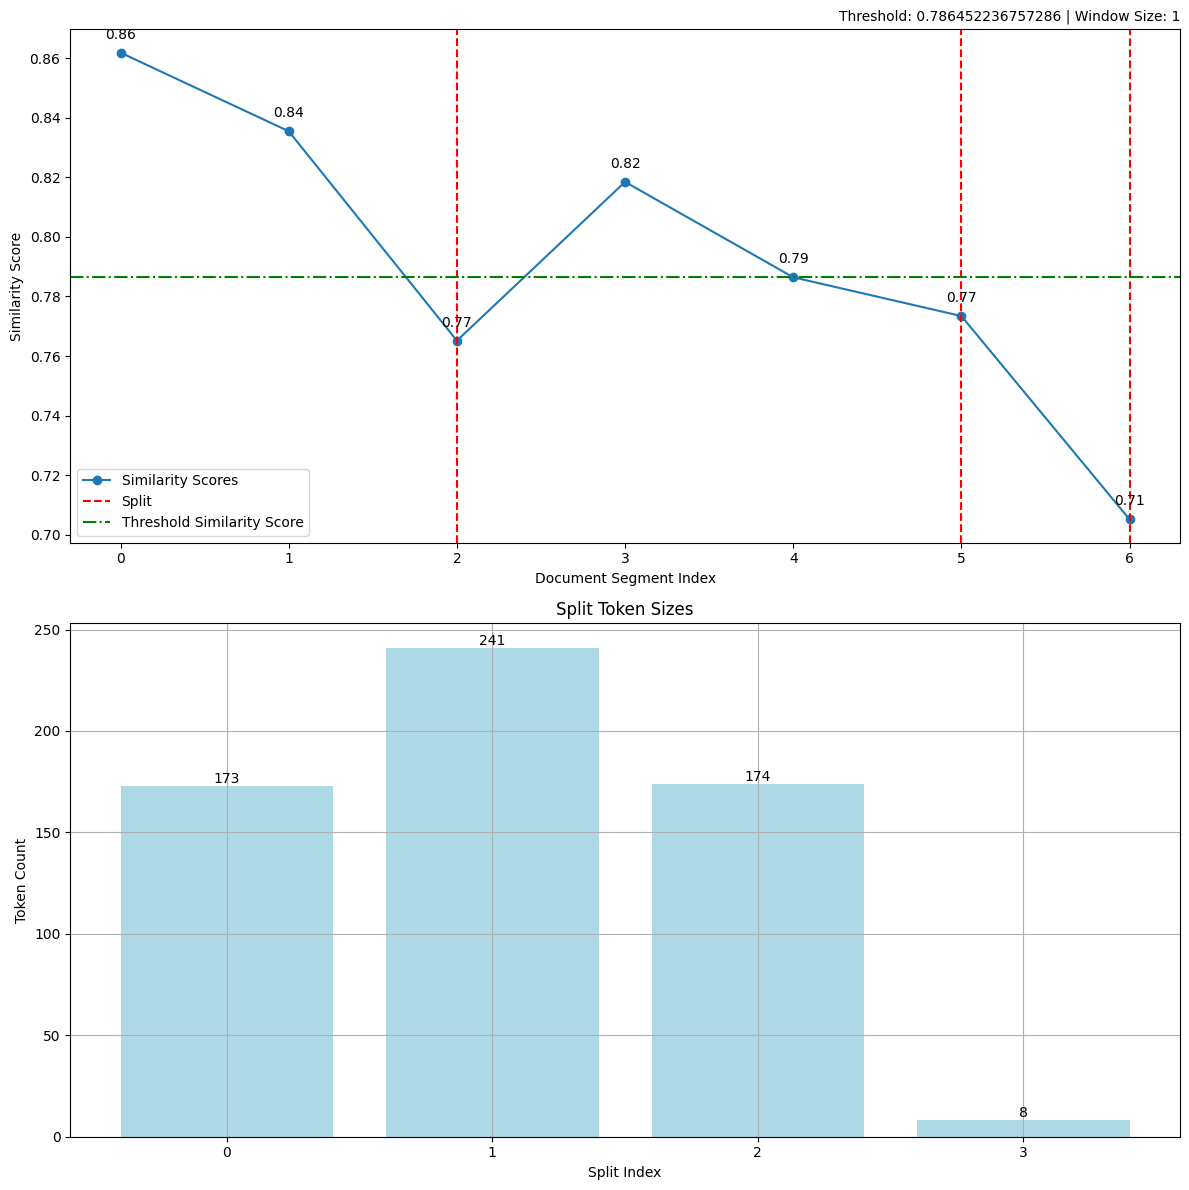

--------------------------------------------------------------------------------
Combined Element Texts: ['Financial Report Chunking for Eﬀective Retrieval Augmented Generation', 'Furthermore, we would like to study the impact of RAG conﬁguration and ele- ment type based chunking.']


2024-02-26 13:24:31 INFO semantic_router.utils.logger Optimal threshold 0.8250029487527775 found with median tokens (41.0) in target range (1-500).
2024-02-26 13:24:31 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 41
  - Maximum Token Size of Split: 41
  - Similarity Split Ratio: 0.00


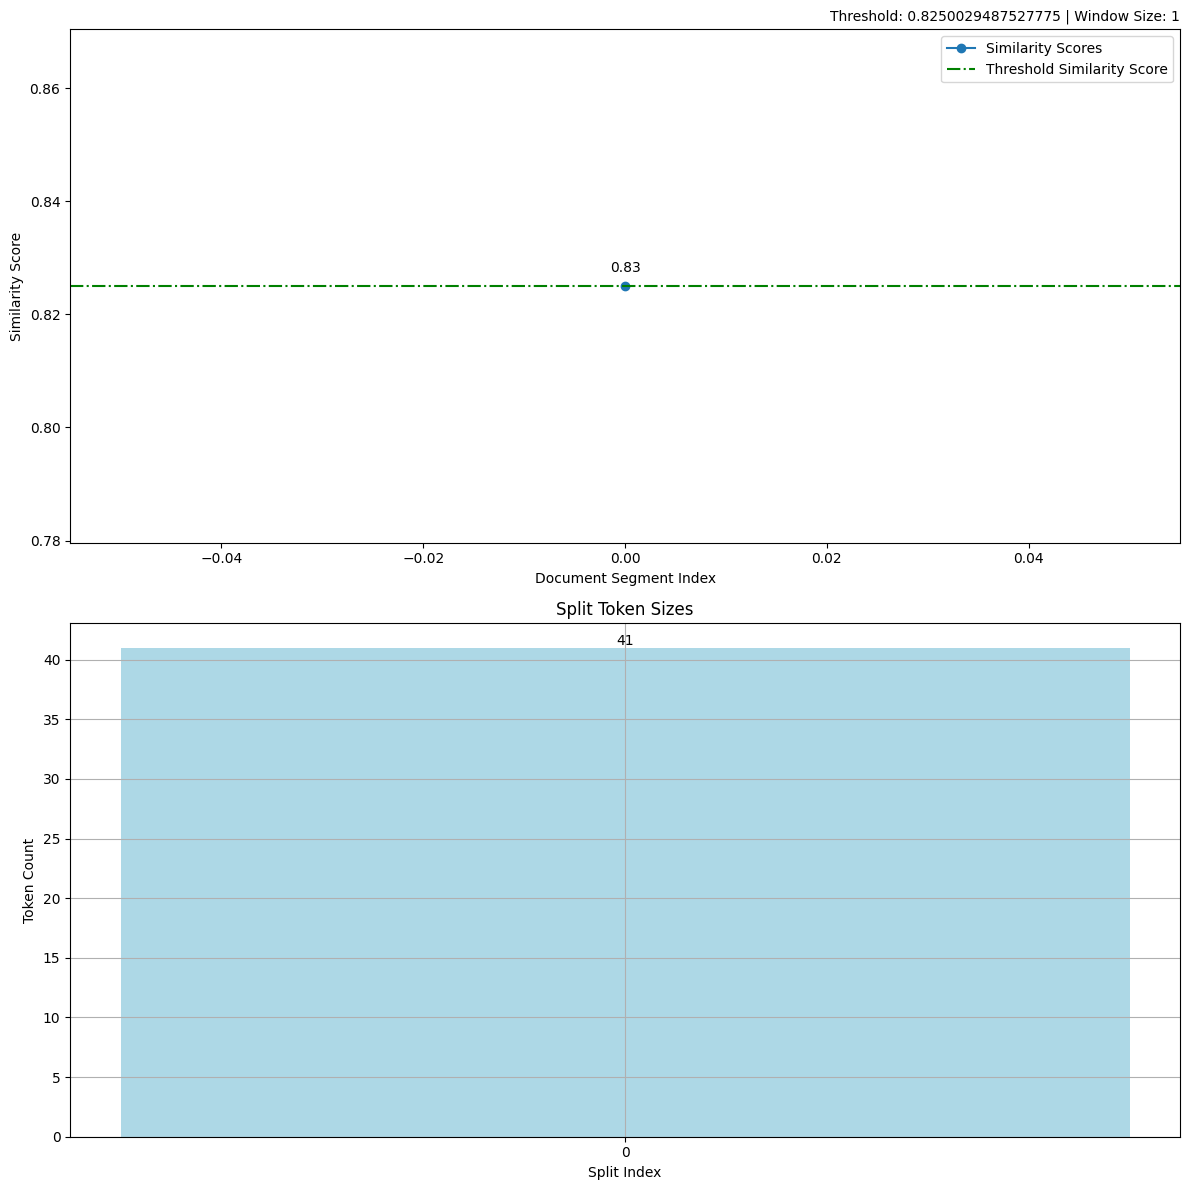

--------------------------------------------------------------------------------
Combined Element Texts: ['2. Balaguer, A., Benara, V., de Freitas Cunha, R.L., de M. Estev˜ao Filho, R., Hendry, T., Holstein, D., Marsman, J., Mecklenburg, N., Malvar, S., Nunes, L.O., Padilha, R., Sharp, M., Silva, B., Sharma, S., Aski, V., Chandra, R.: Rag vs ﬁne-tuning: Pipelines, tradeoﬀs, and a case study on agriculture (2024)', '3. Barnett, S., Kurniawan, S., Thudumu, S., Brannelly, Z., Abdelrazek, M.: Seven Failure Points When Engineering a Retrieval Augmented Generation System (2024)', '4. Bentabet, N.I., Juge, R., El Maarouf, I., Mouilleron, V., Valsamou-Stanislawski, D., El-Haj, M.: The ﬁnancial document structure extraction shared task (ﬁntoc 2020). In: Proceedings of the 1st Joint Workshop on Financial Narrative Processing and MultiLing Financial Summarisation. pp. 13–22 (2020)', '5. Chen, H., Jiao, F., Li, X., Qin, C., Ravaut, M., Zhao, R., Xiong, C., Joty, S.: Chat- GPT’s One-year Anniversar

2024-02-26 13:24:32 INFO semantic_router.utils.logger Optimal threshold 0.8086380431197726 found with median tokens (116.0) in target range (1-500).
2024-02-26 13:24:32 INFO semantic_router.utils.logger Splitting Statistics:
  - Total Splits: 22
  - Splits by Threshold: 21
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 4
  - Maximum Token Size of Split: 513
  - Similarity Split Ratio: 0.95


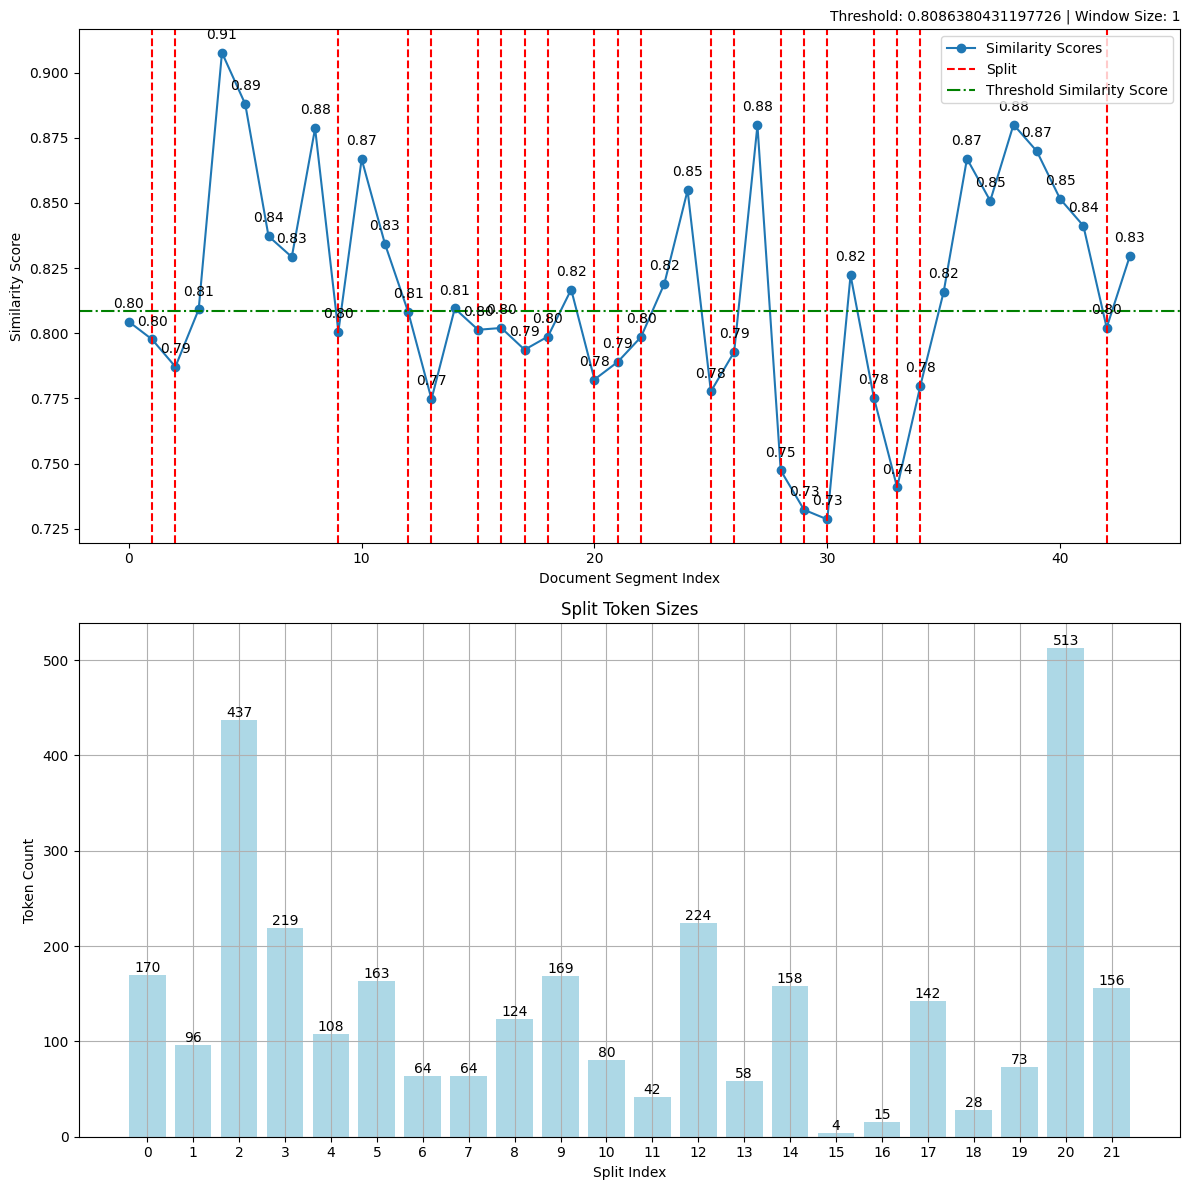

--------------------------------------------------------------------------------


In [21]:
chunks_by_title = create_title_chunks(grouped_elements, splitter)

In [22]:
print_chunks_by_title(chunks_by_title)

NarrativeText,"61,780"
Title,"29,664"
ListItem,"33,054"
UncategorizedText,"9,400"
Footer,"1,026"
Table,"7,700"
Header,"3,959"
Image,26
FigureCaption,54
Formula,29
Address,229
